In [21]:
# !pip install statsmodels

In [84]:
import numpy as np
import pandas as pd
import json
import functools
import math

import statsmodels.api as sm

import matplotlib.pyplot as plt 
%matplotlib inline

import random as rand

from collections import Counter

import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

In [33]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

Then we load the data. We will also print a list of each columns together with its datatype, using the "type" function.

In [2]:
np.random.seed(26)
df = pd.read_csv('tmdb_5000_movies.csv') # Load in the csv file 
print(df.shape)
df = df.loc[~((df['budget'] == 0) | (df['revenue'] == 0))]
print(df.shape)

feature_names = df.columns
for i in range(len(feature_names)):
    print(str(i), "\t", str(feature_names[i]),"\t\t\t", str(type(df.iloc[0,i])))

(4803, 20)
(3229, 20)
0 	 budget 			 <class 'numpy.int64'>
1 	 genres 			 <class 'str'>
2 	 homepage 			 <class 'str'>
3 	 id 			 <class 'numpy.int64'>
4 	 keywords 			 <class 'str'>
5 	 original_language 			 <class 'str'>
6 	 original_title 			 <class 'str'>
7 	 overview 			 <class 'str'>
8 	 popularity 			 <class 'numpy.float64'>
9 	 production_companies 			 <class 'str'>
10 	 production_countries 			 <class 'str'>
11 	 release_date 			 <class 'str'>
12 	 revenue 			 <class 'numpy.int64'>
13 	 runtime 			 <class 'numpy.float64'>
14 	 spoken_languages 			 <class 'str'>
15 	 status 			 <class 'str'>
16 	 tagline 			 <class 'str'>
17 	 title 			 <class 'str'>
18 	 vote_average 			 <class 'numpy.float64'>
19 	 vote_count 			 <class 'numpy.int64'>


# 1. Dealing with Nan/empty data

Our goal is to predict the success of a movie (represented by its revenue) provided a list of features.

In [3]:
# delete id column (which is not relevent to our task)
df = df.drop(["id"], axis=1)
print(df.shape)

feature_names = df.columns

# delete rows which contains empty field
for feature in feature_names:
    if (feature != "homepage" and feature != "tagline"):
        df[feature].replace('', np.nan, inplace=True)
        df = df[~df[feature].isna()]
    else:
        df[feature].replace(np.nan, "", inplace=True)

print(df.shape)

(3229, 19)
(3229, 19)


# 2. Split Train/Test

optional: k-fold etc.

In [69]:
df = df.sample(frac = 1) # we shuffle the data so that our train/test split will be truly random

train_proportion = 0.8
n = len(df)
print('Size of dataset: ', str(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
t = int(train_proportion * n)

def regression_to_classification(i):
    return int(math.log10(abs(i)))

target = df['revenue']
labels = df.loc[:, df.columns.isin(['revenue'])].applymap(regression_to_classification)
data = df.loc[:, ~df.columns.isin(['revenue'])]

# the following variable records the features of examples in the training set
train_x = data.iloc[0:t]
# the following variable records the features of examples in the test set
test_x = data.iloc[t:]
# the following variable records the labels of examples in the training set
train_y = target[0:t]
# the following variable records the labels of examples in the test set
test_y = target[t:]
# the following variable records the label of examples in the training set
train_label = labels[0:t]
# the following variable records the label of examples in the test set
test_label = labels[t:]

# let's take a look
print('Training dataset: ', train_x)
print('Training y: ',train_y)
print('Training label: ',train_label)

Size of dataset:  3229
Training dataset:          budget                                             genres  \
1499  32500000  [{"id": 35, "name": "Comedy"}, {"id": 10749, "...   
1893  25000000  [{"id": 14, "name": "Fantasy"}, {"id": 27, "na...   
2037  22000000  [{"id": 35, "name": "Comedy"}, {"id": 10751, "...   
2610  16000000  [{"id": 18, "name": "Drama"}, {"id": 53, "name...   
3622   5000000                    [{"id": 37, "name": "Western"}]   
...        ...                                                ...   
2662  10000000  [{"id": 18, "name": "Drama"}, {"id": 10752, "n...   
3086  10000000  [{"id": 28, "name": "Action"}, {"id": 35, "nam...   
740   70000000  [{"id": 878, "name": "Science Fiction"}, {"id"...   
2066  18000000  [{"id": 878, "name": "Science Fiction"}, {"id"...   
1258  40000000  [{"id": 35, "name": "Comedy"}, {"id": 18, "nam...   

                                   homepage  \
1499       http://www.bridesmaidsmovie.com/   
1893  http://www.dontbeafraidofthed

# 3. Boolean and Real Value Data

homepage: whether a movie has a home page

In [70]:
# change homepage to boolean feature: whether a movie has a home page
def string_to_bool(string):
    if (string != ""):
        return True
    return False

# change tagline to int feature: length of the tagline (if no tagline, len = 0)
def string_to_int(string):
    try:
        return len(string.split())
    except:
        return 0

In [71]:
type(train_x['vote_count'][0])

numpy.int64

In [7]:
label_str_to_bool = ['homepage']
label_str_to_int = ['tagline']
label_str_to_real = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']

train_vals_homepage = np.asarray(train_x.loc[:, train_x.columns.isin(label_str_to_bool)].applymap(string_to_bool))
test_vals_homepage = np.asarray(test_x.loc[:, test_x.columns.isin(label_str_to_bool)].applymap(string_to_bool))

train_vals_tagline = np.asarray(train_x.loc[:, train_x.columns.isin(label_str_to_int)].applymap(string_to_int))
test_vals_tagline = np.asarray(test_x.loc[:, test_x.columns.isin(label_str_to_int)].applymap(string_to_int))

train_vals_real = np.asarray(train_x.loc[:, train_x.columns.isin(label_str_to_real)])
test_vals_real = np.asarray(test_x.loc[:, test_x.columns.isin(label_str_to_real)])

# 4. Onehot Data

features: production company，country, spoken language

In [8]:
def string_to_list(string):
    data = json.loads(string)
    result = {d['id']: d['name'] for d in data}
    return result.values()

label_str_onehot = [
    'original_language', 
]

# print(train_x.columns)

#Sets of all categories in a particular column
label_onehot_set = [train_x.loc[:, label].fillna('NaN').unique() for label in label_str_onehot]
print(label_onehot_set[0])

def onehot(column=None, col=None):
    # print(col)
    result = []
    for data in column:
        # print(data)
        dic = dict.fromkeys(list(col), 0)
        # print(dic)
        if data in dic.keys():
            dic[data] += 1
        result.append(list(dic.values()))
    return result

train_vals_onehot = train_x.loc[:, train_x.columns.isin(label_str_onehot)]
test_vals_onehot = test_x.loc[:, test_x.columns.isin(label_str_onehot)]

def process_onehot():
    trains = np.ones((len(train_vals_onehot),1))
    tests = np.ones((len(test_vals_onehot),1))
    for i in range(len(label_str_onehot)):
        train_data_col = train_vals_onehot[label_str_onehot[-i]]
        # print(label_str_onehot[-i])
        test_data_col = test_vals_onehot[label_str_onehot[-i]]
        feature_list = label_onehot_set[-i]
        train_vector = onehot(train_data_col, feature_list)
        # print(feature_list)
        test_vector = onehot(test_data_col, feature_list)
        trains = np.concatenate((train_vector, trains), 1)
        tests = np.concatenate((test_vector, tests), 1)
    # print(trains[:, :-1].shape)
    # print(trains[:, :-1])
    return trains[:, :-1], tests[:, :-1]

train_vals_onehot, test_vals_onehot = process_onehot()
print(train_vals_onehot[0])

['en' 'ro' 'zh' 'de' 'ja' 'fr' 'es' 'th' 'ko' 'cn' 'da' 'hi' 'af' 'id'
 'fa' 'ru' 'it' 'vi' 'xx' 'is' 'pl' 'no' 'he' 'nl' 'pt']
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


# 5. Manyhot Data

In [9]:
def string_to_list(string):
    data = json.loads(string)
    result = {d['id']: d['name'] for d in data}
    return result.values()

def string_to_list_prod_countries(string):
    data = json.loads(string)
    result = {d['iso_3166_1']: d['iso_3166_1'] for d in data}
    return result.values()

def string_to_list_spoken_lang(string):
    data = json.loads(string)
    result = {d['iso_639_1']: d['iso_639_1'] for d in data}
    return result.values()

def manyhot(column=None, col=None):
    cat_to_idx = {cat: i for i, cat in enumerate(col)}
    manyhot_vectors = []
    for entry in column:
        vec = [0] * len(col)
        for ele in entry:
            if (ele in cat_to_idx):
                vec[cat_to_idx[ele]] = 1
        manyhot_vectors.append(vec)
    return np.asarray(manyhot_vectors)

label_str_to_dict = ['genres', 'keywords', 'production_companies']
train_vals_genres_keywords = train_x.loc[:, train_x.columns.isin(label_str_to_dict)].applymap(string_to_list)
test_vals_genres_keywords = test_x.loc[:, test_x.columns.isin(label_str_to_dict)].applymap(string_to_list)

# set of all genres
all_genres = functools.reduce(lambda x, y: x.union(y), train_vals_genres_keywords['genres'], set())
train_vals_genres = manyhot(column=train_vals_genres_keywords['genres'], col=all_genres)
test_vals_genres = manyhot(column=test_vals_genres_keywords['genres'], col=all_genres)

In [10]:
# Flatten the list of lists into a single list using a list comprehension
prod_company_list = [company for sublist in train_vals_genres_keywords['production_companies'] for company in sublist]
prod_company_freq = Counter(prod_company_list)
# Create a list of companies to remove
prod_company_to_remove = [company for company, count in prod_company_freq.items() if count <= 3]
# Remove the keys from the dictionary
for company in prod_company_to_remove:
    del prod_company_freq[company]
all_prod_companies = prod_company_freq.keys()
train_vals_prod_company = manyhot(column=train_vals_genres_keywords['production_companies'], col=all_prod_companies)
test_vals_prod_company = manyhot(column=test_vals_genres_keywords['production_companies'], col=all_prod_companies)

In [11]:
# Flatten the list of lists into a single list using a list comprehension
flat_keywords_list = [keyword for sublist in train_vals_genres_keywords['keywords'] for keyword in sublist]
keywords_freq = Counter(flat_keywords_list)
# Create a list of keys to remove
keys_to_remove = [key for key, count in keywords_freq.items() if count <= 3]
# Remove the keys from the dictionary
for key in keys_to_remove:
    del keywords_freq[key]
all_keywords = keywords_freq.keys()
train_vals_keywords = manyhot(column=train_vals_genres_keywords['keywords'], col=all_keywords)
test_vals_keywords = manyhot(column=test_vals_genres_keywords['keywords'], col=all_keywords)

In [12]:
# feature of spoken language
train_spoken_lang_keywords = train_x.loc[:, train_x.columns.isin(['spoken_languages'])].applymap(string_to_list_spoken_lang)
test_spoken_lang_keywords = test_x.loc[:, test_x.columns.isin(['spoken_languages'])].applymap(string_to_list_spoken_lang)
# set of all spoken lang
all_lang = functools.reduce(lambda x, y: x.union(y), train_spoken_lang_keywords['spoken_languages'], set())
train_vals_lang = manyhot(column=train_spoken_lang_keywords['spoken_languages'], col=all_lang)
test_vals_lang = manyhot(column=test_spoken_lang_keywords['spoken_languages'], col=all_lang)

In [13]:
# feature of production_countries
train_prod_country_keywords = train_x.loc[:, train_x.columns.isin(['production_countries'])].applymap(string_to_list_prod_countries)
test_prod_country_keywords = test_x.loc[:, test_x.columns.isin(['production_countries'])].applymap(string_to_list_prod_countries)
# set of all spoken lang
all_prod_country = functools.reduce(lambda x, y: x.union(y), train_prod_country_keywords['production_countries'], set())
train_vals_prod_country = manyhot(column=train_prod_country_keywords['production_countries'], col=all_prod_country)
test_vals_prod_country = manyhot(column=test_prod_country_keywords['production_countries'], col=all_prod_country)

In [14]:
# label_str_onehot = [
#     'production_companies', 
#     'production_countries', 
#     'spoken_languages'
# ]
# print(train_x['spoken_languages'][0])
# print(train_vals_prod_company.shape)
# print(train_vals_lang[5])
# print(train_vals_prod_country[0])

In [15]:
train_offset = np.ones((train_vals_homepage.shape[0], 1))
test_offset = np.ones((test_vals_homepage.shape[0], 1))
train_vals = np.concatenate((train_vals_homepage, train_vals_tagline, train_vals_onehot, train_vals_real, train_vals_prod_company, train_vals_prod_country, train_vals_lang, train_vals_genres, train_offset), axis=1)
test_vals = np.concatenate((test_vals_homepage, test_vals_tagline, test_vals_onehot, test_vals_real, test_vals_prod_company, test_vals_prod_country, test_vals_lang, test_vals_genres, test_offset), axis=1)

In [16]:
# This function just computes the mean squared error
def MSE(y, pred):
    return np.mean(np.square(y - pred))

In [17]:
# This function runs OLS and bypasses any SVD (Singular Value Decomposition) convergence errors by refitting the model
def run_OLS(train_y, test_y, train_vals, test_vals):
    ols_model = sm.regression.linear_model.OLS(train_y, train_vals)
    while True: # Bypasses SVD convergence assertion error
        try:
            results = ols_model.fit()
            break
        except:
            None
            
    w = np.array(results.params).reshape([len(results.params),1])

    train_pred = np.matmul(train_vals,w)
    test_pred = np.matmul(test_vals,w)

    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())
    
    return train_MSE, test_MSE, test_pred

In [18]:
train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_vals, test_vals)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

Train MSE	 6217725970139330.0
Test MSE	 1.1012154387664824e+16


In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

# Create a nonlinear model
model_classifier = MLPClassifier(hidden_layer_sizes=(20, 20))
model_regressor = MLPRegressor(hidden_layer_sizes=(20, 20))

# Train the model on the train set
model_classifier.fit(train_vals, train_label)
model_regressor.fit(train_vals, train_y)

MLPRegressor(hidden_layer_sizes=(20, 20))

In [20]:
# Predict the labels of the test set
train_pred = model_classifier.predict(train_vals)
test_pred = model_classifier.predict(test_vals)

# Evaluate the performance of the model on the test set
accuracy_train = accuracy_score(train_label, train_pred)
accuracy_test = accuracy_score(test_label, test_pred)

# Print the accuracy score
print("Train accuracy:", accuracy_train)
print("Test accuracy:", accuracy_test)

Train accuracy: 0.48819202477739065
Test accuracy: 0.456656346749226


In [21]:
# Predict the labels of the test set
train_pred = model_regressor.predict(train_vals)
test_pred = model_regressor.predict(test_vals)

# Evaluate the performance of the model on the test set
print(metrics.r2_score(train_y, train_pred))
print(metrics.mean_squared_log_error(train_y, train_pred))
print(metrics.r2_score(test_y, test_pred))
print(metrics.mean_squared_log_error(test_y, test_pred))

0.4837691599574987
2.792671523971754
0.544166831992302
2.1071090462212045


# 6. Correlation Visualization

<AxesSubplot: >

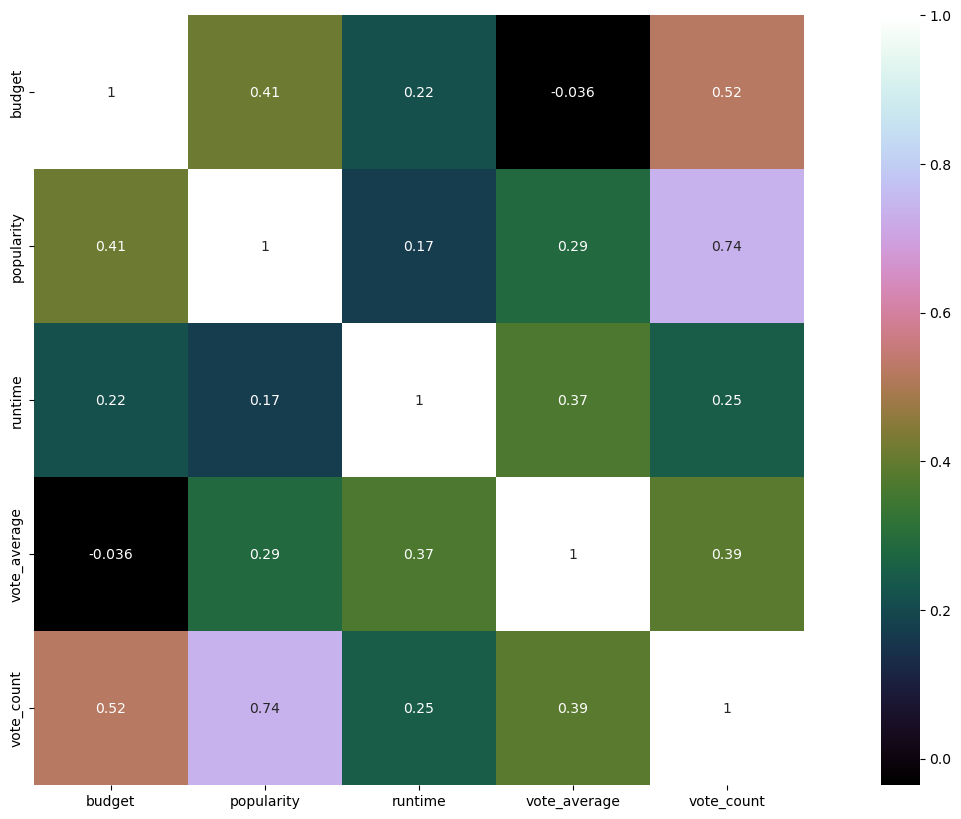

In [25]:
corr_mat = train_x.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

It seems that popularity and vote_count have stronger correlation compared to other pair of features.

<AxesSubplot: xlabel='popularity', ylabel='vote_count'>

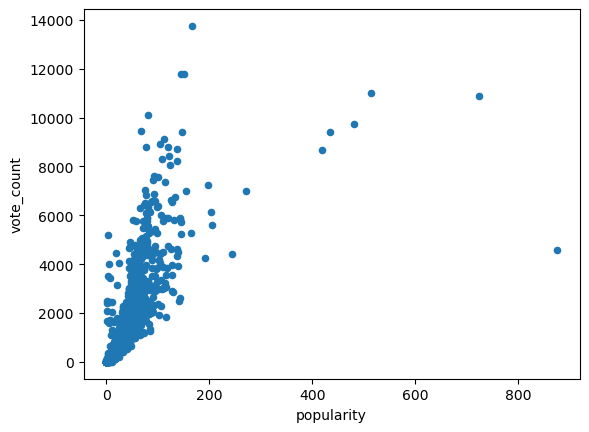

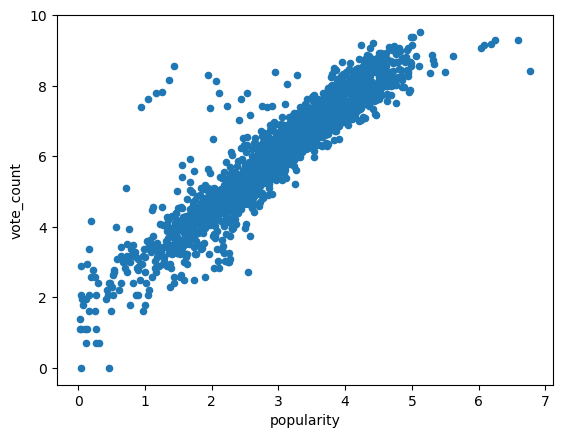

In [72]:
train_x.plot(kind='scatter', x='popularity', y='vote_count')

copy = train_x.copy()
train_x2 = train_x.copy()

train_x2[['popularity', 'vote_count']] = np.log(copy[['popularity', 'vote_count']] + 1)
train_x2.plot(kind='scatter', x='popularity', y='vote_count')

# 7. PCA

Text(0, 0.5, 'Cumulative explained variance')

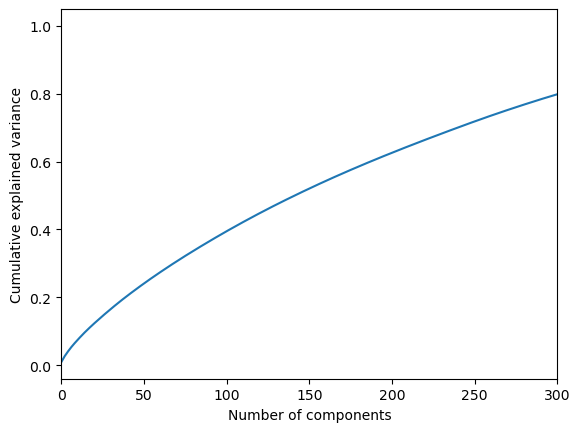

In [52]:
train_x_pca = train_vals.copy()

std_x = StandardScaler().fit_transform(train_x_pca)

pca = PCA().fit(std_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,300,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

It seems that we need around 300 components to account for 70% - 80% of the variance.

# 8. Models

## 8.1. Ridge Regression

In [32]:
## ridge, knn, svm, random forest, k-means

In [34]:
from sklearn import linear_model

In [40]:
print(type(train_y))

<class 'pandas.core.series.Series'>


In [53]:
model_ridge = linear_model.Ridge()
model_ridge.fit(train_vals, train_y)

train_preds_ridge = model_ridge.predict(train_vals)
test_preds_ridge = model_ridge.predict(test_vals)

acc_train_ridge = metrics.r2_score(train_y, train_preds_ridge)
acc_test_ridge = metrics.r2_score(test_y, test_preds_ridge)

# Print the accuracy score
print("Train accuracy:", acc_train_ridge)
print("Test accuracy:", acc_test_ridge)

Train accuracy: 0.8094283200237374
Test accuracy: 0.7553785960638251


Text(0.5, 1.0, 'Residual plot in Ridge Regression')

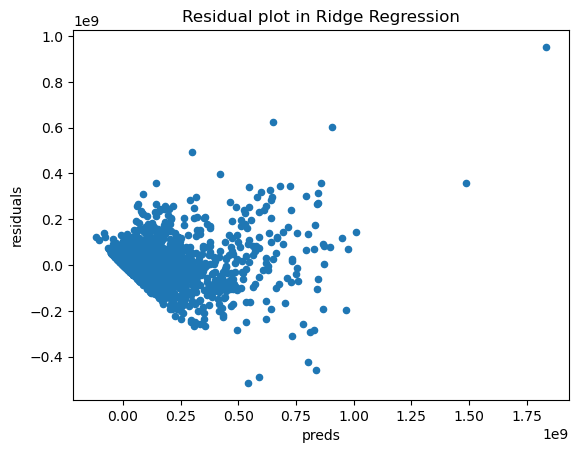

In [55]:
preds_ridge = pd.DataFrame({"preds": train_preds_ridge, "true": train_y})
preds_ridge["residuals"] = preds_ridge["true"] - preds_ridge["preds"]
preds_ridge.plot(x = "preds", y = "residuals", kind = "scatter")
plt.title("Residual plot in Ridge Regression")

## 8.2. KNN

In [57]:
from sklearn import neighbors

k = 5
knn = neighbors.KNeighborsRegressor(k, weights='uniform')
knn.fit(train_vals, train_y)

train_preds_knn = knn.predict(train_vals)
test_preds_knn = knn.predict(test_vals)

acc_train_knn = metrics.r2_score(train_y, train_preds_knn)
acc_test_knn = metrics.r2_score(test_y, test_preds_knn)

# Print the accuracy score
print("Train accuracy:", acc_train_knn)
print("Test accuracy:", acc_test_knn)

Train accuracy: 0.7192537144905177
Test accuracy: 0.5684114855927256


Text(0.5, 1.0, 'Residual plot in KNN')

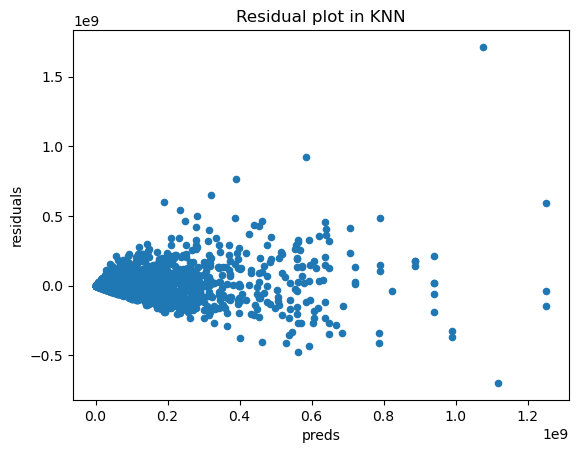

In [58]:
preds_knn = pd.DataFrame({"preds": train_preds_knn, "true": train_y})
preds_knn["residuals"] = preds_knn["true"] - preds_knn["preds"]
preds_knn.plot(x = "preds", y = "residuals", kind = "scatter")
plt.title("Residual plot in KNN")

## 8.3. SVM

In [60]:
from sklearn import svm
svm = svm.SVR()
svm.fit(train_vals, train_y)

train_preds_svm = svm.predict(train_vals)
test_preds_svm = svm.predict(test_vals)

acc_train_svm = metrics.r2_score(train_y, train_preds_svm)
acc_test_svm = metrics.r2_score(test_y, test_preds_svm)

# Print the accuracy score
print("Train accuracy:", acc_train_svm)
print("Test accuracy:", acc_test_svm)

Train accuracy: -0.12508975025058744
Test accuracy: -0.12946749955950088


Negative accuracy indicates that the SVM regressor model does not follow the trends of the data. Really bad performance.

Text(0.5, 1.0, 'Residual plot in SVM')

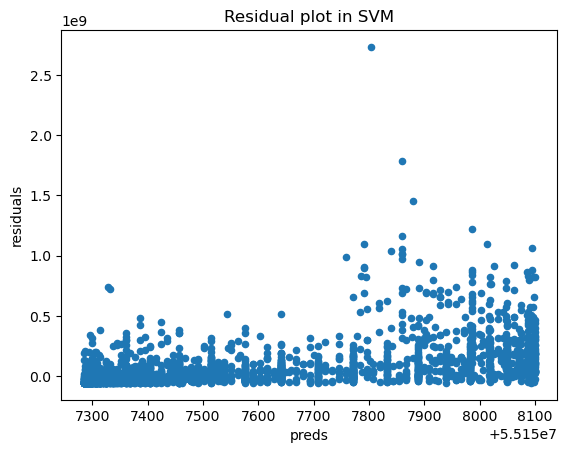

In [61]:
preds_svm = pd.DataFrame({"preds": train_preds_svm, "true": train_y})
preds_svm["residuals"] = preds_svm["true"] - preds_svm["preds"]
preds_svm.plot(x = "preds", y = "residuals", kind = "scatter")
plt.title("Residual plot in SVM")

## 8.4. Decision Tree

In [62]:
from sklearn import tree
model_tree = tree.DecisionTreeRegressor(max_depth=1)
model_tree.fit(train_vals, train_y)

train_preds_tree = model_tree.predict(train_vals)
test_preds_tree = model_tree.predict(test_vals)

acc_train_tree = metrics.r2_score(train_y, train_preds_tree)
acc_test_tree = metrics.r2_score(test_y, test_preds_tree)

# Print the accuracy score
print("Train accuracy:", acc_train_tree)
print("Test accuracy:", acc_test_tree)

Train accuracy: 0.37305380690635637
Test accuracy: 0.44899267549465727


Text(0.5, 1.0, 'Residual plot in Decision Tree')

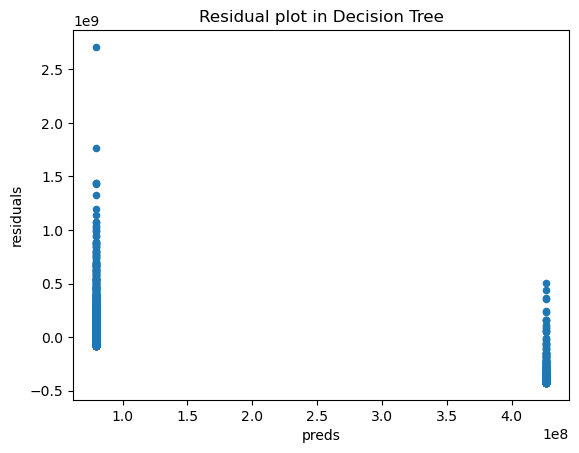

In [80]:
preds_tree = pd.DataFrame({"preds": train_preds_tree, "true": train_y})
preds_tree["residuals"] = preds_tree["true"] - preds_tree["preds"]
preds_tree.plot(x = "preds", y = "residuals", kind = "scatter")
plt.title("Residual plot in Decision Tree")

## 8.5. Random Forest

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

forest = dict(n_estimators=np.linspace(10,40,4).astype(int), min_samples_split=(2,3), min_samples_leaf=(1,2,3))
forest_grid = GridSearchCV(RandomForestRegressor(random_state=42), forest, cv=10)
forest_grid.fit(train_vals, train_y)

print(f'Forest:\n\t *best params: {forest_grid.best_params_}\n\t *best score: {forest_grid.best_score_}')

Forest:
	 *best params: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}
	 *best score: 0.7338310104348615


In [79]:
model_forest = RandomForestRegressor(min_samples_leaf=1, min_samples_split=2, n_estimators=40)
model_forest.fit(train_vals, train_y)

train_preds_forest = model_forest.predict(train_vals)
test_preds_forest = model_forest.predict(test_vals)

acc_train_forest = metrics.r2_score(train_y, train_preds_forest)
acc_test_forest = metrics.r2_score(test_y, test_preds_forest)

# Print the accuracy score
print("Train accuracy:", acc_train_forest)
print("Test accuracy:", acc_test_forest)

Train accuracy: 0.8299486777966402
Test accuracy: -0.10563591994524058


Text(0.5, 1.0, 'Residual plot in Random Forest')

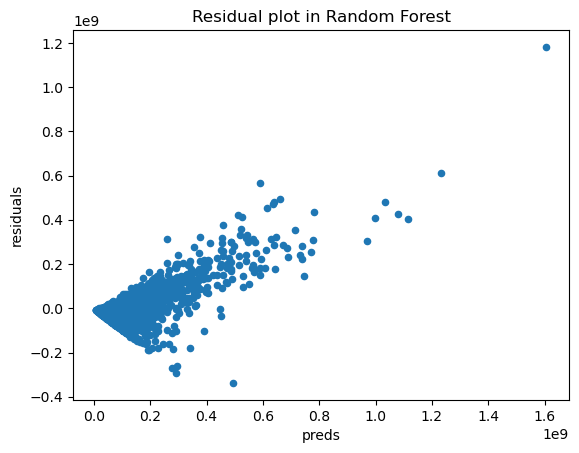

In [81]:
preds_forest = pd.DataFrame({"preds": train_preds_forest, "true": train_y})
preds_forest["residuals"] = preds_forest["true"] - preds_forest["preds"]
preds_forest.plot(x = "preds", y = "residuals", kind = "scatter")
plt.title("Residual plot in Random Forest")

# 9. Model Performances

In [85]:
train_err = [acc_train_ridge, acc_train_knn, acc_train_svm, acc_train_tree, acc_train_forest]
test_err = [acc_test_ridge, acc_test_knn, acc_test_svm, acc_test_tree, acc_test_forest]

col={'Train Error':train_err,'Test Error':test_err}
models = ['Ridge Regression','Knn','SVM','Decision Tree','Random Forest']
df = pd.DataFrame(data=col,index=models)
df

,Train Error,Test Error
Ridge Regression,0.809428,0.755379
Knn,0.719254,0.568411
SVM,-0.125090,-0.129467
Decision Tree,0.373054,0.448993
Random Forest,0.829949,-0.105636
